<a href="https://colab.research.google.com/github/gulierus/VU_RG/blob/main/NEW_PFN_REPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================
# SETUP - Nový PFNs repozitář
# =============================================
import os
os.chdir('/content')

!rm -rf /content/PFNs
!cd /content && git clone https://github.com/automl/PFNs.git
!cd /content/PFNs && pip install -e . -q

print("PFNs nainstalováno")


Cloning into 'PFNs'...
remote: Enumerating objects: 870, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 870 (delta 95), reused 94 (delta 76), pack-reused 745 (from 1)
Receiving objects: 100% (870/870), 95.48 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (595/595), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.1 MB/s eta 0:00:00

In [ ]:
# =============================================
# IMPORTS
# =============================================
import sys
sys.path.insert(0, '/content/PFNs')

import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from pfns import utils
from pfns.model import bar_distribution
from pfns.train import train, MainConfig, OptimizerConfig, TransformerConfig, BatchShapeSamplerConfig
from pfns.model.encoders import EncoderConfig
from pfns.model.bar_distribution import BarDistributionConfig
from pfns.priors.prior import AdhocPriorConfig
from pfns.priors import Batch
from pfns.priors.fast_gp import get_batch as get_batch_for_gp

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Device: {device}")
print(f"✓ PyTorch: {torch.__version__}")

✓ Device: cuda
✓ PyTorch: 2.9.0+cu126


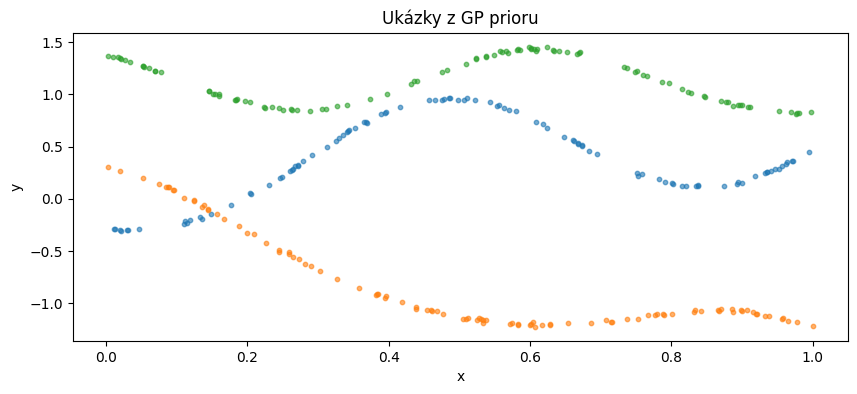

Batch shapes: x=torch.Size([3, 100, 1]), y=torch.Size([3, 100])


In [ ]:
# =============================================
# GP PRIOR - Sampling funkce
# =============================================

# Ukázka dat z GP prioru
hps_gp = {"noise": 1e-4, "outputscale": 1., "lengthscale": 0.3}

batch = get_batch_for_gp(batch_size=3, seq_len=100, num_features=1, hyperparameters=hps_gp)

plt.figure(figsize=(10, 4))
for i in range(len(batch.x)):
    plt.scatter(batch.x[i, :, 0].cpu().numpy(), batch.y[i, :].cpu().numpy(), alpha=0.6, s=10)
plt.title('Ukázky z GP prioru')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(f"Batch shapes: x={batch.x.shape}, y={batch.y.shape}")

In [ ]:
# =============================================
# CONFIGURATIONS
# =============================================

# Hyperparametry GP prioru
hps = {"noise": 1e-4, "outputscale": 1., "lengthscale": 0.3}

# Training konfigurace
num_features = 1
max_dataset_size = 50
epochs = 20
batch_size = 64
steps_per_epoch = 100

print(f"✓ Konfigurace:")
print(f"  GP: lengthscale={hps['lengthscale']}, outputscale={hps['outputscale']}, noise={hps['noise']}")
print(f"  Training: epochs={epochs}, batch_size={batch_size}, steps_per_epoch={steps_per_epoch}")
print(f"  Celkem datasetů: {epochs * steps_per_epoch * batch_size:,}")

✓ Konfigurace:
  GP: lengthscale=0.3, outputscale=1.0, noise=0.0001
  Training: epochs=20, batch_size=64, steps_per_epoch=100
  Celkem datasetů: 128,000


In [ ]:
# =============================================
# TRAINING SETUP
# =============================================

def train_gp_pfn(get_batch_function, epochs=50, num_features=1, max_dataset_size=100,
                 hps=None, batch_size=128, steps_per_epoch=100):
    """
    Trénuje PFN pro GP prior pomocí oficiálního API.
    """

    # Sample y hodnoty pro bar distribution borders
    print("Sampling y values pro bar distribution...")
    ys = get_batch_function(10000, max_dataset_size, num_features, hyperparameters=hps).target_y
    borders = bar_distribution.get_bucket_borders(num_outputs=1000, ys=ys).tolist()
    print(f"✓ Bar distribution: 1000 bars, y range: [{min(borders):.2f}, {max(borders):.2f}]")

    # Konfigurace
    config = MainConfig(
        priors=[AdhocPriorConfig(
            get_batch_methods=[get_batch_function],
            prior_kwargs={'num_features': num_features, 'hyperparameters': hps}
        )],
        optimizer=OptimizerConfig('adamw', lr=0.0003),
        model=TransformerConfig(
            criterion=BarDistributionConfig(full_support=True, borders=borders),
            emsize=512,
            nhead=8,
            nhid=1024,
            nlayers=6,
            features_per_group=1,
            attention_between_features=False,
            encoder=EncoderConfig(
                constant_normalization_mean=0.5,
                constant_normalization_std=math.sqrt(1/12)
            )
        ),
        batch_shape_sampler=BatchShapeSamplerConfig(
            batch_size=batch_size,
            max_seq_len=max_dataset_size,
            min_num_features=num_features,
            max_num_features=num_features
        ),
        epochs=epochs,
        warmup_epochs=epochs // 4,
        steps_per_epoch=steps_per_epoch,
        num_workers=0,
    )

    print(f"\n{'='*60}")
    print("TRAINING PFN pro Gaussian Process")
    print(f"{'='*60}")

    train_result = train(config, device='cuda', reusable_config=False)

    return train_result

In [ ]:
# =============================================
# TRAINING
# =============================================

train_result = train_gp_pfn(
    get_batch_for_gp,
    epochs=epochs,
    num_features=num_features,
    max_dataset_size=max_dataset_size,
    hps=hps,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch
)

trained_model = train_result['model']

print(f"\n{'='*60}")
print("✓ Training dokončen!")
print(f"{'='*60}")

Sampling y values pro bar distribution...
✓ Bar distribution: 1000 bars, y range: [-4.17, 4.56]

TRAINING PFN pro Gaussian Process
init dist
Not using distributed
ALL: Using device cuda.
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<pfns.priors.fast_gp.get_batch (batch_size, seq_len, num_features, device='cuda:0', hyperparameters=None, equidistant_x=False, fix_x=None, **kwargs)
), num_features=1, hyperparameters={'noise': 0.0001, 'outputscale': 1.0, 'lengthscale': 0.3}), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=64, min_single_eval_pos=0, max_seq_len=50, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.par


Vizualizace...


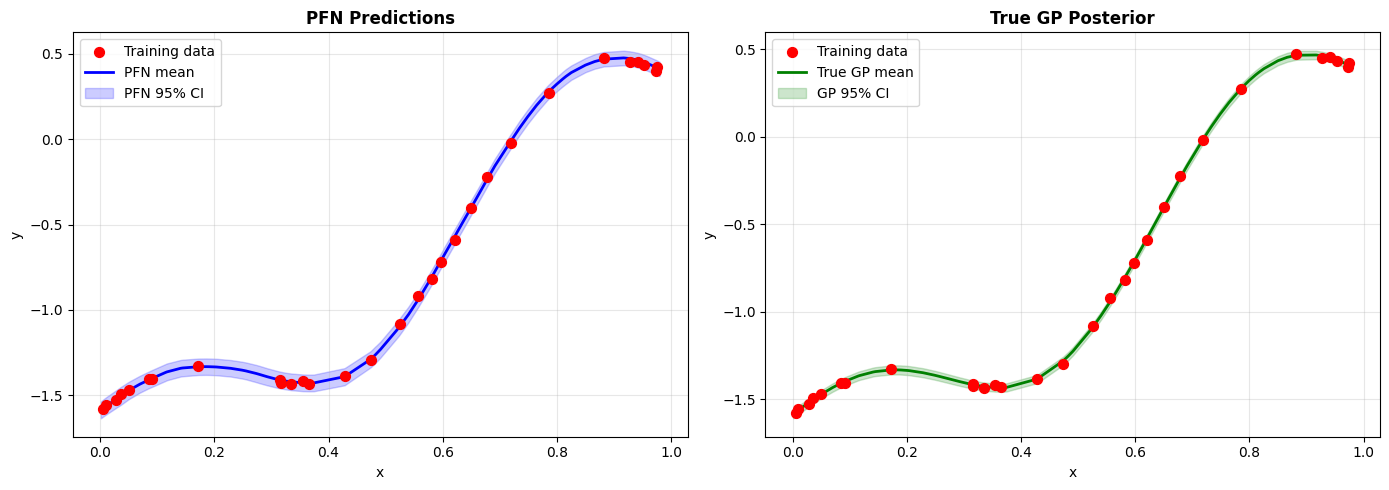


MSE (PFN vs GP): 0.000046
Correlation: 1.0000


In [ ]:
# =============================================
# TRAINING VISUALIZATION
# =============================================

print("\nVizualizace...")

# Sample nová data
batch = get_batch_for_gp(batch_size=2, seq_len=100, num_features=1, hyperparameters=hps)

batch_index = 0
num_training_points = 30

# Data pro vizualizaci
train_x = batch.x[batch_index, :num_training_points].cpu()
train_y = batch.y[batch_index, :num_training_points].cpu()
test_x = batch.x[batch_index].cpu()

# PFN predikce
with torch.no_grad():
    logits = trained_model(train_x[None], train_y[None], test_x[None])

# Mean a confidence intervals
pred_means = trained_model.criterion.mean(logits)[0].cpu()
pred_confs = trained_model.criterion.quantile(logits)[0].cpu()

# Ground truth GP pomocí sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

kernel = ConstantKernel(hps['outputscale']) * RBF(length_scale=hps['lengthscale']) + WhiteKernel(noise_level=hps['noise'])
gp = GaussianProcessRegressor(kernel=kernel, alpha=0)

train_x_np = train_x[..., 0].numpy().reshape(-1, 1)
train_y_np = train_y.numpy()
test_x_np = test_x[..., 0].numpy().reshape(-1, 1)

gp.fit(train_x_np, train_y_np)
gp_mean, gp_std = gp.predict(test_x_np, return_std=True)

order_test_x = test_x[..., 0].argsort()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PFN
ax = axes[0]
ax.scatter(train_x[..., 0], train_y, c='red', s=50, zorder=10, label='Training data')
ax.plot(test_x[order_test_x, 0], pred_means[order_test_x], 'b-', lw=2, label='PFN mean')
ax.fill_between(
    test_x[order_test_x, 0].numpy(),
    pred_confs[order_test_x, 0].numpy(),
    pred_confs[order_test_x, 1].numpy(),
    alpha=0.2, color='blue', label='PFN 95% CI'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('PFN Predictions', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# True GP
ax = axes[1]
test_x_sorted = test_x_np[order_test_x.numpy()].flatten()
gp_mean_sorted = gp_mean[order_test_x.numpy()]
gp_std_sorted = gp_std[order_test_x.numpy()]

ax.scatter(train_x[..., 0], train_y, c='red', s=50, zorder=10, label='Training data')
ax.plot(test_x_sorted, gp_mean_sorted, 'g-', lw=2, label='True GP mean')
ax.fill_between(
    test_x_sorted,
    gp_mean_sorted - 1.96 * gp_std_sorted,
    gp_mean_sorted + 1.96 * gp_std_sorted,
    alpha=0.2, color='green', label='GP 95% CI'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True GP Posterior', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metriky
pfn_means_sorted = pred_means[order_test_x].numpy()
gp_mean_sorted = gp_mean[order_test_x.numpy()]

# Porovnání pouze na test pozicích
test_mask = np.ones(len(test_x), dtype=bool)
test_mask[:num_training_points] = False
test_indices = order_test_x.numpy()[test_mask[order_test_x.numpy()]]

if len(test_indices) > 0:
    mse = np.mean((pred_means[test_indices].numpy() - gp_mean[test_indices]) ** 2)
    corr = np.corrcoef(pred_means.numpy(), gp_mean)[0, 1]

    print(f"\n{'='*60}")
    print(f"MSE (PFN vs GP): {mse:.6f}")
    print(f"Correlation: {corr:.4f}")
    print(f"{'='*60}")


Více příkladů predikce...


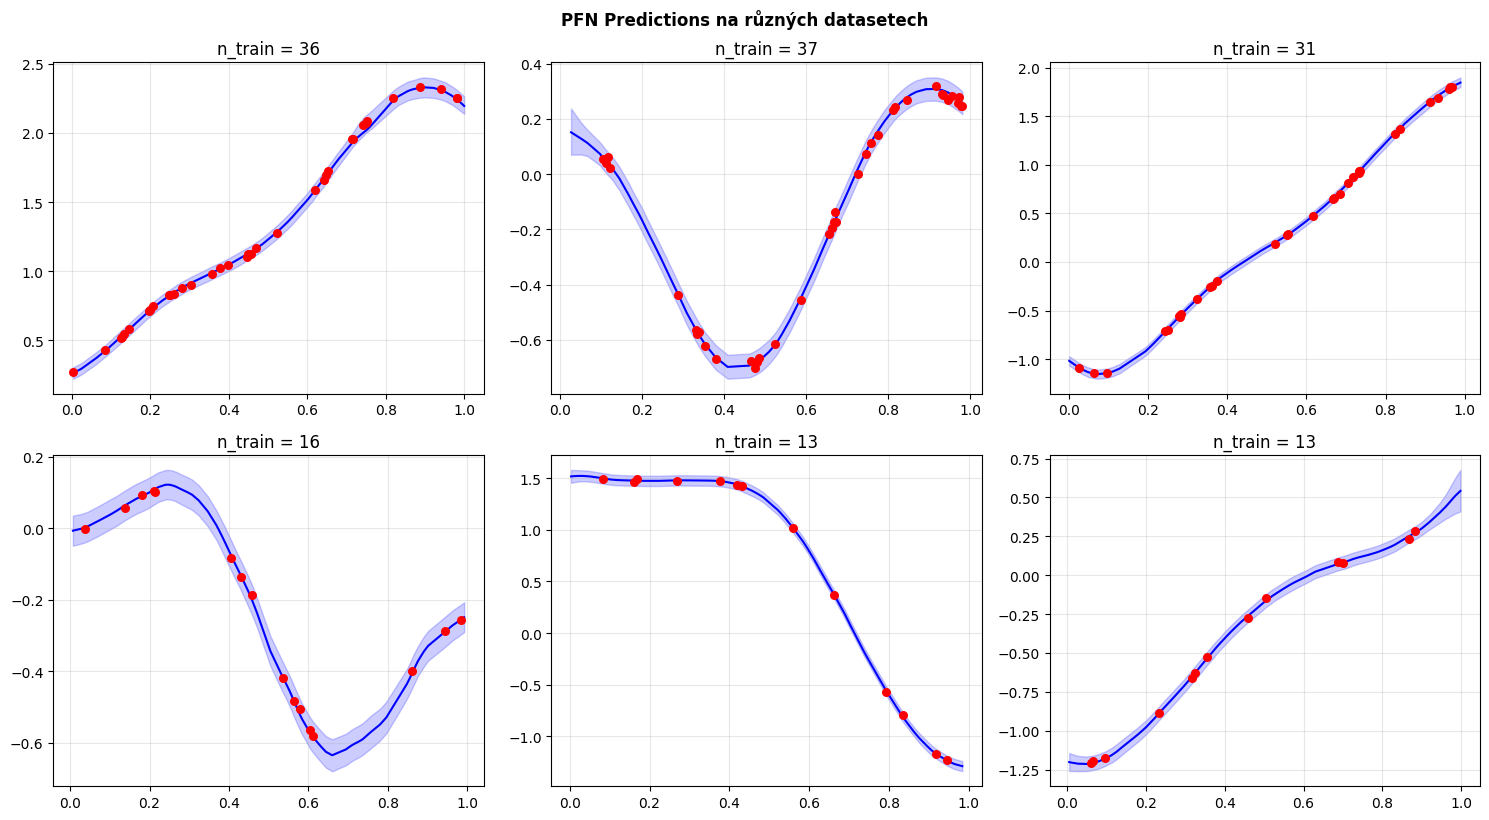

In [ ]:
# =============================================
# VISUALIZATION OF DIFFERENT DATASETS
# =============================================

print("\nVíce příkladů predikce...")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx in range(6):
    batch = get_batch_for_gp(batch_size=1, seq_len=100, num_features=1, hyperparameters=hps)

    num_train = np.random.randint(10, 40)

    train_x = batch.x[0, :num_train].cpu()
    train_y = batch.y[0, :num_train].cpu()
    test_x = batch.x[0].cpu()

    with torch.no_grad():
        logits = trained_model(train_x[None], train_y[None], test_x[None])

    pred_means = trained_model.criterion.mean(logits)[0].cpu()
    pred_confs = trained_model.criterion.quantile(logits)[0].cpu()

    order = test_x[..., 0].argsort()

    ax = axes[idx]
    ax.scatter(train_x[..., 0], train_y, c='red', s=30, zorder=10)
    ax.plot(test_x[order, 0], pred_means[order], 'b-', lw=1.5)
    ax.fill_between(
        test_x[order, 0].numpy(),
        pred_confs[order, 0].numpy(),
        pred_confs[order, 1].numpy(),
        alpha=0.2, color='blue'
    )
    ax.set_title(f'n_train = {num_train}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('PFN Predictions na různých datasetech', y=1.02, fontweight='bold')
plt.show()

In [ ]:
import os
import torch
from google.colab import drive

# 1. Připojení Google Disku
drive.mount('/content/drive')

# 2. Nastavení cesty na Google Disk
# Cesta začíná /content/drive/MyDrive/ což je váš hlavní adresář na Disku
save_dir = '/content/drive/MyDrive/UZNATONEMAMNERVY/PFN_GP_model'
os.makedirs(save_dir, exist_ok=True)

# 3. Uložení modelu
if 'trained_model' in locals() and trained_model is not None:
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'criterion': trained_model.criterion,
        'config': {
            'hps': hps,
            'num_features': num_features,
            'max_dataset_size': max_dataset_size,
            'epochs': epochs,
        },
    }, f'{save_dir}/pfn_gp_model.pth')

    print(f"✓ Model úspěšně uložen na Google Disk: {save_dir}/pfn_gp_model.pth")
else:
    print("[!] Proměnná 'trained_model' neexistuje. Nejdříve spusťte trénování.")

Mounted at /content/drive
✓ Model úspěšně uložen na Google Disk: /content/drive/MyDrive/UZNATONEMAMNERVY/PFN_GP_model/pfn_gp_model.pth


In [ ]:
# Načtení
checkpoint_path = f'{save_dir_drive}/pfn_gp_model.pth'
loaded_model = load_pfn_model(checkpoint_path)